# StatML Testat 3
## Maneuver Detection for Loft Dynamics Helicopter Simulation
Authors: Marcel Schubert, Florian Eugster, Nicola Dall'Acqua
#
#
#
#
#
#

### Imports

In [25]:
import pandas as pd
import pyarrow          # Required for pandas read_parquet()
import os
import json
import seaborn as sns

### 1. Reading, Splitting according to project documentation and visualizing data

In [2]:
# Moving reserved data (as specified in project documentation) to test folder
# 6 out of 19 test flights were designated test data, i.e. ~31%
test_path = os.path.join('data', 'test')
if not os.path.exists(test_path):
    os.makedirs(test_path)
    
    files_to_move = [
        '0b3f3902-2c04-4625-8576-3bb963e3d709',
        '663f573a-74c5-4368-b60b-1fb433cd835d',
        '8c36586f-94e9-4ae9-8384-0f3342008677',
        'a376807a-82d3-4526-b19f-98d4b3f9078b',
        'd76bb0eb-bc08-4b35-8c1f-37369452083d',
        'f40f71de-5cc2-4719-8a5a-abcf950cbd71'
    ]
    
    for file_id in files_to_move:
        parquet_file = os.path.join('data', f'{file_id}.parquet')
        json_file = os.path.join('data', f'{file_id}.json')
        os.replace(parquet_file, os.path.join(test_path, f'{file_id}.parquet'))
        os.replace(json_file, os.path.join(test_path, f'{file_id}.json'))


# Preprocessing
Aufgrund der Datengrösse müssen die Preprocessing-Schritte auf den einzelnen Dateien ausgeführt werden

In [ ]:
# loads file from data_path as parquet into dataframe
# maps column names from col_map_path
# and adds dependent variable 'maneuver' from annotations_path and maps to corresponding timestamps
# currently only retains numeric and bool values
def preprocess_file(data_path, col_map_path, annotations_path, debug=False):
    # Validate input types and existence of files
    for path, name in zip([data_path, col_map_path, annotations_path], 
                          ['data_path', 'col_map_path', 'annotations_path']):
        if not isinstance(path, str):
            raise ValueError(f"{name} is not a string")
        if not os.path.isfile(path):
            raise ValueError(f"{name} does not exist")

    # Read the DataFrame from the Parquet file
    df = pd.read_parquet(data_path, engine='pyarrow')

    df = df.convert_dtypes()  # Automatically convert columns to the best possible dtypes

    # Load state descriptions
    with open(col_map_path) as json_data:
        state_descriptions = json.load(json_data)

    # Create a mapping from stateId to column names
    state_id_to_col_name = {
        str(desc['stateId']): col_name for col_name, desc in state_descriptions.items()
    }

    # Rename DataFrame columns if they match a stateId in the state descriptions
    df.rename(columns=lambda x: state_id_to_col_name.get(str(x), x), inplace=True)

    # Ensure timestamp is part of the MultiIndex
    if not isinstance(df.index, pd.MultiIndex) or 'TimeStamp' not in df.index.names:
        raise ValueError("Expected a MultiIndex with 'TimeStamp' as one of the levels.")

    # Convert the TimeStamp index to UTC if it is timezone naive
    timestamp_index = df.index.get_level_values('TimeStamp')
    if timestamp_index.dtype == 'datetime64[ns]':
        df.index = df.index.set_levels([timestamp_index.tz_localize('UTC')])

    # Load annotations
    with open(annotations_path) as json_file:
        annotations = json.load(json_file)

    # Create the maneuver column and initialize it to None
    df['maneuver'] = None  

    # Apply annotation labels based on the timestamp level in the MultiIndex
    for annotation in annotations['annotations']:
        start = pd.to_datetime(annotation['startTimestamp']).tz_localize('UTC')
        end = pd.to_datetime(annotation['endTimeStamp']).tz_localize('UTC')
        maneuver = annotation['comment']

        # Create a mask for the relevant MultiIndex level
        mask = (timestamp_index >= start) & (timestamp_index <= end)
        df.loc[mask, 'maneuver'] = maneuver  # Fill the maneuver column in bulk

    # Forward fill NaN or None values
    # Explicitly convert object columns if necessary

    df.ffill(inplace=True)

    # Convert boolean columns to integers and float64 columns to float32
    df = df.astype({col: 'int8' for col in df.select_dtypes(include='boolean').columns})
    df = df.astype({col: 'float32' for col in df.select_dtypes(include='float64').columns})

    # Drop all string columns except 'maneuver'
    df = df.drop(columns=df.select_dtypes(include='string').columns.difference(['maneuver']))
    df['maneuver'] = df['maneuver'].fillna('no maneuver').astype('category')
    df['maneuver'] = df['maneuver'].cat.codes
    df = df.drop(columns=df.select_dtypes(include='object').columns)

    # Debugging information
    if debug:
        print(df.head())
    
    return df

In [111]:
# applies rolling window on maneuver dataframe
# beware of scaling since it iterates over the whole dataset with the window size
# currently only means the numeric values and makes majority vote on the maneuver
def preprocess_df(df, window=5, default_maneuver=0):
    # Validate that the window parameter is an integer
    if not isinstance(window, int):
        raise ValueError("window must be an integer")

    # Identify numeric columns excluding 'maneuver' if it's int8
    numeric_cols = df.select_dtypes(include='number').columns.difference(['maneuver'], sort=False)

    # Apply a rolling mean to numeric columns
    df[numeric_cols] = df[numeric_cols].rolling(window=window, min_periods=window).mean()  # Calculate rolling mean

    # Check if the 'maneuver' column exists before processing
    if 'maneuver' in df.columns:
        # Calculate the rolling mode for the 'maneuver' column
        df['maneuver'] = df['maneuver'].rolling(window=window, min_periods=1).apply(
            lambda x: x.mode()[0] if not x.mode().empty else default_maneuver,
            raw=False
        )

        # Ensure that the 'maneuver' column remains of type int8
        df['maneuver'] = df['maneuver'].astype('int8')
    else:
        # If the column doesn't exist, create it with the default maneuver
        df['maneuver'] = default_maneuver

    return df


In [134]:
df = preprocess_file(
        os.path.join('data', '0bbf0c4e-fb3c-4213-bff8-ef21ee5ebf79.parquet'),
        os.path.join('data', 'StateDescriptions.json'),
        os.path.join('data', '0bbf0c4e-fb3c-4213-bff8-ef21ee5ebf79.json'),
    )

In [ ]:
df = preprocess_df(df,window=10000)


In [139]:
df = df.dropna()

In [158]:
df.describe()

,Ios_Malfunction_ShedBusPP46Failure_Available,Ios_FlightAssistance_ClimbRate,Ios_Malfunction_CWPLightGeneratorCaution_Available,Ios_Controls_RadarAltimeter_OnOff_Available,Maintenance_Test_Number_Max,Ios_Malfunction_CWPFailure_Available,Hardware_GMA350H_AudioVolume,Ios_Malfunction_CWPLightHydraulicsWarning,Ios_Simulation_PointLightGroup_6_Max,Ios_Aircraft_Option_PedalsFlipped,...,Ios_Repos_Quick_Heading_Min,Aerofly_Out_Aircraft_VerticalSpeed,Ios_Simulation_Layers_1_Min,Ios_Malfunction_CWPDoorCaution,Ios_Malfunction_BatteryFailure,Ios_Malfunction_NRN2Failure,Hardware_VEMD_Brightness_Plus,Ios_Weight_Passenger_Back3,Ios_Malfunction_TailRotorPowerLoss_Max,maneuver
count,179765.0,179765.0,179765.0,179765.0,179765.0,179765.0,179765.0,179765.0,179765.0,179765.0,...,179765.0,179765.000000,179765.0,179765.0,179765.0,179765.0,179765.0,179765.0,179765.0,179765.000000
mean,0.0,0.0,0.0,0.0,10.0,0.0,0.0,1.0,1.0,1.0,...,0.0,-0.087227,0.0,1.0,1.0,1.0,0.0,0.0,1.0,2.626184
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.918171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.510672
min,0.0,0.0,0.0,0.0,10.0,0.0,0.0,1.0,1.0,1.0,...,0.0,-6.215708,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.000000
25%,0.0,0.0,0.0,0.0,10.0,0.0,0.0,1.0,1.0,1.0,...,0.0,-0.502077,0.0,1.0,1.0,1.0,0.0,0.0,1.0,2.000000
50%,0.0,0.0,0.0,0.0,10.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.052055,0.0,1.0,1.0,1.0,0.0,0.0,1.0,2.000000
75%,0.0,0.0,0.0,0.0,10.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.098572,0.0,1.0,1.0,1.0,0.0,0.0,1.0,4.000000
max,0.0,0.0,0.0,0.0,10.0,0.0,0.0,1.0,1.0,1.0,...,0.0,4.092914,0.0,1.0,1.0,1.0,0.0,0.0,1.0,6.000000


6
2
0
5
3
4
1


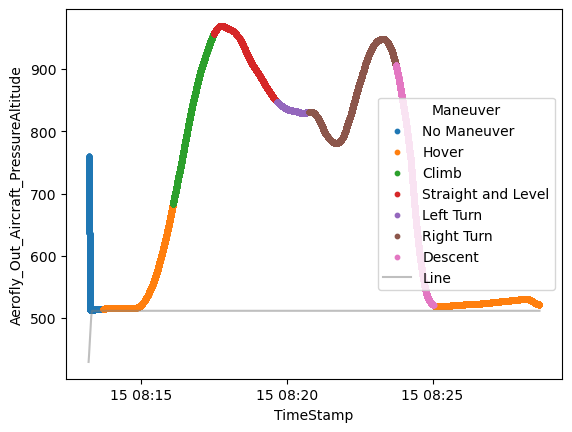

In [ ]:
import matplotlib.pyplot as plt

def plot_maneuvers(df, ax):
    # Define a mapping from maneuver codes to string representations
    maneuver_labels = {
        0: 'Climb',
        1: 'Descent',
        2: 'Hover',
        3: 'Left Turn',
        4: 'Right Turn',
        5: 'Straight and Level',
        6: 'No Maneuver'
    }

    # Create a scatter plot with points colored by maneuver
    for maneuver in df['maneuver'].unique():
        maneuver_data = df[df['maneuver'] == maneuver]
        ax.scatter(maneuver_data.index.get_level_values('TimeStamp'), maneuver_data['Aerofly_Out_Aircraft_PressureAltitude'], label=maneuver_labels.get(maneuver, f'Maneuver {maneuver}'), s=10)

    # Add another line to the plot
    #ax.plot(df.index.get_level_values('TimeStamp'), df['Aerofly_In_Weather_Pressure_QNHAltitude'], color='gray', alpha=0.5, label='Line')

    # Add labels and legend
    ax.set_xlabel('TimeStamp')
    ax.set_ylabel('Aerofly_Out_Aircraft_PressureAltitude')
    ax.legend(title='Maneuver')


# Create a plot
fig, ax = plt.subplots()
plot_maneuvers(df, ax)
plt.show()


In [2]:
df_train_array = []
labels_train_array = []
df_test_array = []
labels_test_array = []
state_descriptions = {}

In [ ]:
# TODO: Increase jupyter RAM limit to allow loading entire dataset
# Alternatively, load data in chunks

#if not df_train_array:
#iterate
for file in os.listdir (os.path.join('data')):
    # handle test files
    #if file == 'test':
    #    for test_file in os.listdir(os.path.join('data', 'test')):
    #        if test_file.lower().endswith('.parquet'):
    #            df_test_array.append(pd.read_parquet(os.path.join('data', 'test', test_file), engine='pyarrow'))
    #        else:
    #            with open(os.path.join('data', 'test', test_file)) as json_data:
    #                labels_test_array.append(json.load(json_data))
    if file == 'test':
        continue
    elif file == 'StateDescriptions.json':
        with open(os.path.join('data', file)) as json_data:
            state_descriptions = json.load(json_data)

    #handle training data
    elif file.lower().endswith('.parquet'):
        df_train_array.append(pd.read_parquet(os.path.join('data', file), engine='pyarrow'))
    elif file.lower().endswith('.json'):
        with open(os.path.join('data', file)) as json_data:
            labels_train_array.append(json.load(json_data))
    else:
        raise Exception("Unknown file")

#print(df_train_array[0].head())
print(labels_train_array)

AttributeError: 'numpy.int64' object has no attribute 'endswith'